In [2]:
import os
import cv2
import copy
import time
import glob
import random
import datetime
import numpy as np
import pandas as pd
import skimage.io as io
import matplotlib.pyplot as plt
from collections import Counter
from tqdm.notebook import tqdm
from pycocotools.coco import COCO
import sys
sys.path
sys.path.append('../')
print(sys.path)
import pprint
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms as T

import skimage.io
import skimage.transform
import skimage.color
import skimage



['C:\\Users\\admin\\Documents\\GitHub\\2021-AI-Highly-Cluttered-Dataset\\metric_hyun', 'C:\\Users\\admin\\anaconda3\\python37.zip', 'C:\\Users\\admin\\anaconda3\\DLLs', 'C:\\Users\\admin\\anaconda3\\lib', 'C:\\Users\\admin\\anaconda3', '', 'C:\\Users\\admin\\anaconda3\\lib\\site-packages', 'C:\\Users\\admin\\anaconda3\\lib\\site-packages\\win32', 'C:\\Users\\admin\\anaconda3\\lib\\site-packages\\win32\\lib', 'C:\\Users\\admin\\anaconda3\\lib\\site-packages\\Pythonwin', 'C:\\Users\\admin\\anaconda3\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\admin\\.ipython', '../']


In [3]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

## Dataset / DataLoader

In [4]:
# I believe that train image will be performed well (test image, of course, will fail)
#test_images = glob.glob('/DATASET/COCO-Dataset/images/test2017/*.jpg')

In [5]:
#FIXED_IMAGE_SHAPE = (640, 480)
BASE_IMG_PATH = 'D:/Dataset/Coco/'
BASE_ANN_PATH = 'D:/Dataset/Coco/annotations'

#TRAIN_IMG_PATH = os.path.join(BASE_IMG_PATH, 'train2017')
#TRAIN_ANN_PATH = os.path.join(BASE_ANN_PATH, 'instances_train2017.json')

VALID_IMG_PATH = os.path.join(BASE_IMG_PATH, 'val2014')
VALID_ANN_PATH = os.path.join(BASE_ANN_PATH, 'instances_val2014.json')
#TEST_IMG_PATH = os.path.join(BASE_IMG_PATH, 'test2017')
# TEST_ANN_PATH = os.path.join(BASE_ANN_PATH, 'instances_test2017.json')  # NO DATA!
train_images = glob.glob(VALID_IMG_PATH+'/*.jpg')


In [6]:
from torchvision.datasets import CocoDetection
from pycocotools.coco import COCO


In [7]:
#dataset_coco_valid
FIXED_IMAGE_SHAPE = (640, 480)

## High-pass Frequency / Low-pass Frequency

In [7]:
class Resizer(object):
    """Convert ndarrays in sample to Tensors."""
    def __init__(self, img_size):
        self.img_size = img_size

    def __call__(self, image,annots):
        rows, cols, cns = image.shape

        largest_side = max(rows, cols)

        scale = self.img_size / largest_side

        # resize the image with the computed scale
        image = skimage.transform.resize(image, (int(round(rows*scale)), int(round((cols*scale)))))
        rows, cols, cns = image.shape

        new_image = np.zeros((self.img_size, self.img_size, cns)).astype(np.float32)
        new_image[:rows, :cols, :] = image.astype(np.float32)

        annots['boxes']*= scale
        annots['scale'] = torch.as_tensor(scale)
        return T.ToTensor()(new_image),annots
from torch.utils.data import Dataset, DataLoader    
class Customized_CoCDetection(CocoDetection):
    def __init__(self, root, annFile, transform,kernel_size=5,high=None,low=None):
        super().__init__(root, annFile=annFile)
        self.kernel_size=kernel_size
        self.high=high
        self.low=low
        self.transforms = transform
    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]["file_name"]
        bgr_img = cv2.imread(os.path.join(self.root, path))
        rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
        return rgb_img

    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))
    def _lff(self,img,k=1):
        lpf_img =cv2.GaussianBlur(img,(k,k),sigmaX=0,sigmaY=0,borderType=cv2.BORDER_DEFAULT)
        return lpf_img
    def _hff(self,img,k=1):
        img = cv2.Laplacian(img,cv2.CV_8U,ksize=k)
        return img
    
    def __getitem__(self, index: int):
        img_id = self.ids[index]
        image = self._load_image(img_id)
        ori_image=image.copy()
        if self.high:
            image=self._hff(image,self.kernel_size)
        elif self.low:
            image=self._lff(image,self.kernel_size)
        
        coco_annotation = self._load_target(img_id)
        num_objs = len(coco_annotation)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        labels=[]
        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]
            labels.append(coco_annotation[i]['category_id'])
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        #labels = torch.ones((num_objs,), dtype=torch.int64)
        # Tensorise img_id
        labels = torch.tensor([labels])                          
        img_id = torch.tensor([img_id])
        # Size of bbox (Rectangular)
        areas = []
        for i in range(num_objs):
            areas.append(coco_annotation[i]['area'])
        areas = torch.as_tensor(areas, dtype=torch.float32)
        # Iscrowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Annotation is in dictionary format
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        my_annotation["iscrowd"] = iscrowd
        #return image,my_annotation
        if self.transforms is not None:
            image, my_annotation = self.transforms(image, my_annotation)
        else:
            image=T.ToTensor()(image)
        

        return image, my_annotation#,ori_image

In [8]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [17]:
# select device (whether GPU or CPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# DataLoader is iterable over Dataset
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

model.eval()
model.to(device)


In [10]:
train_batch_size = 16

#model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# select device (whether GPU or CPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device="cuda"
# DataLoader is iterable over Dataset
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

model.eval()
model.to(device)
print("")

In [11]:
standard_data_set=Customized_CoCDetection(root=VALID_IMG_PATH,
                                   annFile=VALID_ANN_PATH,
                                    kernel_size=3,
                                   transform=Resizer(400),
                                   high=None)

#  Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.383
#  Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.595
#  Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.417
#  Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.167
#  Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.419
#  Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.549
#  Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.314
#  Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.479
#  Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.497
#  Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.240
#  Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.547
#  Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.698

hf_data_set=Customized_CoCDetection(root=VALID_IMG_PATH,
                                   annFile=VALID_ANN_PATH,
                                    kernel_size=3,
                                   transform=Resizer(400),
                                   high=True)

#  Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.073
#  Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.125
#  Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.076
#  Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.010
#  Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.066
#  Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.143
#  Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.093
#  Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.116
#  Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.117
#  Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.013
#  Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.101
#  Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.245

lf_data_set=Customized_CoCDetection(root=VALID_IMG_PATH,
                                   annFile=VALID_ANN_PATH,
                                    kernel_size=3,
                                   transform=Resizer(400),
                                   low=True)

loading annotations into memory...
Done (t=9.04s)
creating index...
index created!
loading annotations into memory...
Done (t=8.53s)
creating index...
index created!
loading annotations into memory...
Done (t=8.91s)
creating index...
index created!


In [ ]:
import json   
from pycocotools.cocoeval import COCOeval

SEED = 2021
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)  # type: ignore
torch.backends.cudnn.deterministic = True  # type: ignore
torch.backends.cudnn.benchmark = True  # type: ignore
data_loader = torch.utils.data.DataLoader(standard_data_set,
                                          batch_size=16,
                                          shuffle=False,
                                          collate_fn=collate_fn)

model.eval()
threshold=0.5
with torch.no_grad():

    # start collecting results
    results = []
    image_ids = []
    for index,(imgs, annotations) in enumerate(data_loader):
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        outputs=model(imgs)
        for idx,output in enumerate(outputs):
            scores = output['scores'].cpu()
            labels = output['labels'].cpu()
            boxes  = output['boxes'].cpu()
            # correct boxes for image scale
            boxes /= annotations[idx]['scale']

            if boxes.shape[0] > 0:
                # change to (x, y, w, h) (MS COCO standard)
                boxes[:, 2] -= boxes[:, 0]
                boxes[:, 3] -= boxes[:, 1]

                # compute predicted labels and scores
                #for box, score, label in zip(boxes[0], scores[0], labels[0]):
                for box_id in range(boxes.shape[0]):
                    score = float(scores[box_id])
                    label = int(labels[box_id])
                    box = boxes[box_id, :]

                    # scores are sorted, so we can break
                    if score < threshold:
                        break

                    # append detection for each positively labeled class
                    image_result = {
                        'image_id'    : annotations[idx]['image_id'].item(),
                        'category_id' : label,
                        'score'       : float(score),
                        'bbox'        : box.tolist(),
                    }

                    # append detection to results
                    results.append(image_result)

            # append image to list of processed images
            image_ids.append(annotations[idx]['image_id'].item())

        # print progress
        print('{}/{}'.format(index, len(data_loader)), end='\r')
        if index ==1000:
            break
    # write output
    json.dump(results, open('{}_bbox_results.json'.format("standard"), 'w'), indent=4)

    # load results in COCO evaluation tool
    coco_true = hf_data_set.coco
    coco_pred = coco_true.loadRes('{}_bbox_results.json'.format("standard"))

    # run COCO evaluation
    coco_eval = COCOeval(coco_true, coco_pred, 'bbox')
    coco_eval.params.imgIds = image_ids
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
    

..\torch\csrc\utils\python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


In [ ]:
data_loader = torch.utils.data.DataLoader(hf_data_set,
                                          batch_size=16,
                                          shuffle=False,
                                          collate_fn=collate_fn)

model.eval()
threshold=0.5
with torch.no_grad():

    # start collecting results
    results = []
    image_ids = []
    for index,(imgs, annotations) in enumerate(data_loader):
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        outputs=model(imgs)
        for idx,output in enumerate(outputs):
            scores = output['scores'].cpu()
            labels = output['labels'].cpu()
            boxes  = output['boxes'].cpu()
            # correct boxes for image scale
            boxes /= annotations[idx]['scale']

            if boxes.shape[0] > 0:
                # change to (x, y, w, h) (MS COCO standard)
                boxes[:, 2] -= boxes[:, 0]
                boxes[:, 3] -= boxes[:, 1]

                # compute predicted labels and scores
                #for box, score, label in zip(boxes[0], scores[0], labels[0]):
                for box_id in range(boxes.shape[0]):
                    score = float(scores[box_id])
                    label = int(labels[box_id])
                    box = boxes[box_id, :]

                    # scores are sorted, so we can break
                    if score < threshold:
                        break

                    # append detection for each positively labeled class
                    image_result = {
                        'image_id'    : annotations[idx]['image_id'].item(),
                        'category_id' : label,
                        'score'       : float(score),
                        'bbox'        : box.tolist(),
                    }

                    # append detection to results
                    results.append(image_result)

            # append image to list of processed images
            image_ids.append(annotations[idx]['image_id'].item())

        # print progress
        print('{}/{}'.format(index, len(data_loader)), end='\r')
        if index ==1000:
            break
    # write output
    json.dump(results, open('{}_bbox_results.json'.format("standard"), 'w'), indent=4)

    # load results in COCO evaluation tool
    coco_true = hf_data_set.coco
    coco_pred = coco_true.loadRes('{}_bbox_results.json'.format("standard"))

    # run COCO evaluation
    coco_eval = COCOeval(coco_true, coco_pred, 'bbox')
    coco_eval.params.imgIds = image_ids
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
    

In [ ]:
data_loader = torch.utils.data.DataLoader(lf_data_set,
                                          batch_size=16,
                                          shuffle=False,
                                          collate_fn=collate_fn)

model.eval()
threshold=0.5
with torch.no_grad():

    # start collecting results
    results = []
    image_ids = []
    for index,(imgs, annotations) in enumerate(data_loader):
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        outputs=model(imgs)
        for idx,output in enumerate(outputs):
            scores = output['scores'].cpu()
            labels = output['labels'].cpu()
            boxes  = output['boxes'].cpu()
            # correct boxes for image scale
            boxes /= annotations[idx]['scale']

            if boxes.shape[0] > 0:
                # change to (x, y, w, h) (MS COCO standard)
                boxes[:, 2] -= boxes[:, 0]
                boxes[:, 3] -= boxes[:, 1]

                # compute predicted labels and scores
                #for box, score, label in zip(boxes[0], scores[0], labels[0]):
                for box_id in range(boxes.shape[0]):
                    score = float(scores[box_id])
                    label = int(labels[box_id])
                    box = boxes[box_id, :]

                    # scores are sorted, so we can break
                    if score < threshold:
                        break

                    # append detection for each positively labeled class
                    image_result = {
                        'image_id'    : annotations[idx]['image_id'].item(),
                        'category_id' : label,
                        'score'       : float(score),
                        'bbox'        : box.tolist(),
                    }

                    # append detection to results
                    results.append(image_result)

            # append image to list of processed images
            image_ids.append(annotations[idx]['image_id'].item())

        # print progress
        print('{}/{}'.format(index, len(data_loader)), end='\r')
        if index ==1000:
            break
    # write output
    json.dump(results, open('{}_bbox_results.json'.format("standard"), 'w'), indent=4)

    # load results in COCO evaluation tool
    coco_true = hf_data_set.coco
    coco_pred = coco_true.loadRes('{}_bbox_results.json'.format("standard"))

    # run COCO evaluation
    coco_eval = COCOeval(coco_true, coco_pred, 'bbox')
    coco_eval.params.imgIds = image_ids
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
    

In [41]:
lf_data_set=Customized_CoCDetection(root=VALID_IMG_PATH,
                                   annFile=VALID_ANN_PATH,
                                    kernel_size=17,
                                   transform=Resizer(400),
                                   low=True)

loading annotations into memory...
Done (t=6.49s)
creating index...
index created!


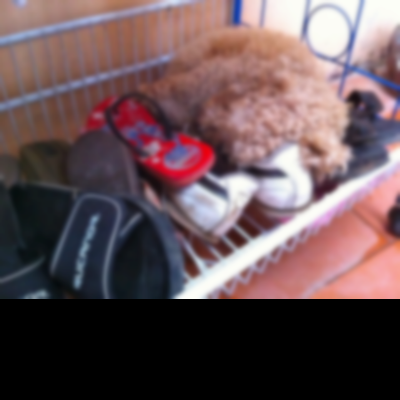

In [42]:
T.ToPILImage()(lf_data_set[0][0])